In [6]:
import mne
import os
import scipy.io
import listen_italian_functions
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from tqdm import tnrange, tqdm_notebook

data_path = os.path.dirname(os.path.dirname(os.getcwd()))

subject_name = ['Alice','Andrea','Daniel','Elena','Elenora','Elisa','Federica','Francesca','Gianluca1','Giada','Giorgia',
                'Jonluca','Laura','Leonardo','Linda','Lucrezia','Manu','Marco','Martina','Pagani','Pasquale','Sara',
                'Silvia','Silvia2','Tommaso']

# reading the coherence


In [7]:
trial_len = 2
remove_first = 0.5 #seconds

save_path = data_path + '/analysis/python/data/coherence'

info = mne.io.read_raw_fif((save_path+'-info'),preload=True)
save_path = data_path + '/analysis/python/data/coherence-trialLen-'+str(trial_len)+'-removedFirst-'+str(remove_first)+'s'

a=[]
for s in subject_name:
    a.append(pd.read_pickle(save_path+'-'+s))

data = pd.concat((a),axis=0)
data['Delay']=data['Delay'] - 0.5
data['Delay']=data['Delay'].round(decimals=1)
data.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)
data.sample(10)

Opening raw data file C:\Users\SMukherjee\Desktop\projects\listen_italian_motor_entrainment\analysis\python\data\coherence-info...
This filename (C:\Users\SMukherjee\Desktop\projects\listen_italian_motor_entrainment\analysis\python\data\coherence-info) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
    Range : 40502 ... 1132918 =     40.502 ...  1132.918 secs
Ready.
Reading 0 ... 1092416  =      0.000 ...  1092.416 secs...


Data  \
Feature      Freq            Condition Delay Subject                                                       
envelop      Theta 4 - 7Hz   Hyper      0.4  Manu      [0.029352651614338202, 0.044245131247090765, 0...   
jawaopening  Beta 13 - 25Hz  Normal    -0.5  Sara      [0.05201306894307033, 0.053768917878108786, 0....   
TBCD         Delta 1 - 3Hz   All        0.2  Andrea    [0.027409084092324336, 0.03298354760585852, 0....   
jawaopening  Alpha 8 - 12Hz  Normal    -0.5  Lucrezia  [0.07537414131008657, 0.06581529659877253, 0.0...   
TTCD         Theta 4 - 7Hz   Normal    -0.3  Leonardo  [0.05715108143519005, 0.03994971205843665, 0.0...   
             Gamma 30 - 40Hz Hypo      -0.3  Manu      [0.08441187432884222, 0.08392259342739623, 0.0...   
lipaparature Alpha 8 - 12Hz  All        0.2  Tommaso   [0.029541272850133027, 0.028287314500318947, 0...   
envelop      Alpha 8 - 12Hz  All       -0.5  Silvia2   [0.03605708488834635, 0.031921522777661714, 0....   
lipaparature Gamma 30 - 40Hz Normal    -0.4  Elena     [0.05879533371481614, 0.06066754225666547, 0.0...   
TTCD         Gamma 30 - 40Hz Hypo      -0.1  Pagani    [0.06485839772321422, 0.08601913854029894, 0.0...   

                                                       noTrials  
Feature      Freq            Condition Delay Subject             
envelop      Theta 4 - 7Hz   Hyper      0.4  Manu            45  
jawaopening  Beta 13 - 25Hz  Normal    -0.5  Sara            49  
TBCD         Delta 1 - 3Hz   All        0.2  Andrea         121  
jawaopening  Alpha 8 - 12Hz  Normal    -0.5  Lucrezia        50  
TTCD         Theta 4 - 7Hz   Normal    -0.3  Leonardo        48  
             Gamma 30 - 40Hz Hypo      -0.3  Manu            26  
lipaparature Alpha 8 - 12Hz  All        0.2  Tommaso        121  
envelop      Alpha 8 - 12Hz  All       -0.5  Silvia2        118  
lipaparature Gamma 30 - 40Hz Normal    -0.4  Elena           50  
TTCD         Gamma 30 - 40Hz Hypo      -0.1  Pagani          26

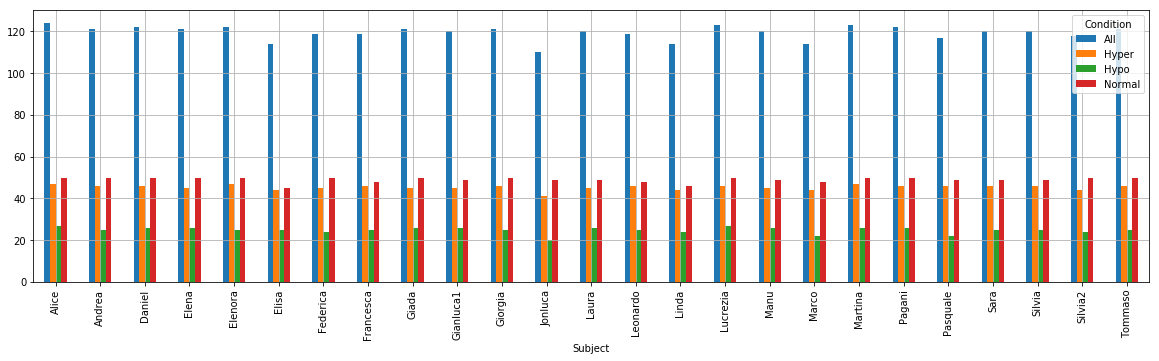

In [8]:
condition = ['Hyper','Normal','Hypo','All']
a=pd.DataFrame(data.loc['envelop','Delta 1 - 3Hz',condition,0,subject_name])
a=a.groupby(['Subject','Condition']).sum()['noTrials'].unstack().plot(kind='bar',figsize=(20,5),grid=True)

In [9]:
def get_coherence_value_delay(data,name,subject_name,delay,condition): 
    D = []
    for d in delay:
        A = []
        for c in condition:
            a  = data.loc[name[0],name[1],c,d,subject_name].as_matrix().mean(axis=0)
            a = a[0].mean()
            A.append(a)
        D.append(A)

    D=np.asarray(D)
    frames=[]
    for c in range(0,len(condition)):
        df = pd.DataFrame({condition[c]:D[:,c]})
        frames.append(df)
    
    df=pd.concat((frames),axis=1)
    df.index = delay
    df.index.name = 'Delay'    
    return df

In [10]:
def get_coherence_value(data,name,subject_name,d,condition):
    x=[]
    for i in condition:
        a  = data.loc[name[0],name[1],i,d,subject_name].as_matrix().mean(axis=0)
        x.append(a[0])

    return x

def plot_coherence(data,vmax,vmin,axes,name,info): 
    im = mne.viz.plot_topomap(data, info.info, axes=axes, show=False,vmin=vmin,vmax=vmax)
    axes.set(title=name)
    return im

def plot_coherence_preprocess(x,name,condition,delay,info):
    vmax=np.amax(np.concatenate(x, axis=0))
    vmin=np.amin(np.concatenate(x, axis=0))

    fig, axes = plt.subplots(1, len(condition),figsize=(10,4))
    for i in range(0,len(condition)):
        im = plot_coherence(x[i],vmax,vmin,axes[i],condition[i],info)

    fig.suptitle(name[0]+'-Delay-'+ str(delay)+ '-'+name[1])
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.35, 0.04, 0.3])
    fig.colorbar(im[0], cax=cbar_ax)
    fig.show()
    
def plot_coherence_preprocess_delay(x,name,condition,delay,info):
    vmax=np.amax(np.concatenate(x, axis=0))
    vmin=np.amin(np.concatenate(x, axis=0))

    fig, axes = plt.subplots(1, len(delay),figsize=(20,6))
    for i in range(0,len(delay)):
        im = plot_coherence(x[i][0],vmax,vmin,axes[i],delay[i],info)

    fig.suptitle(name[0]+ ' - '+name[1]+' - '+ str(condition[0]),y=0.7)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.50, 0.01, 0.15])
    fig.colorbar(im[0], cax=cbar_ax)
    fig.show()

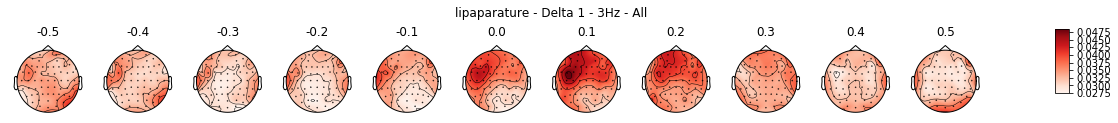

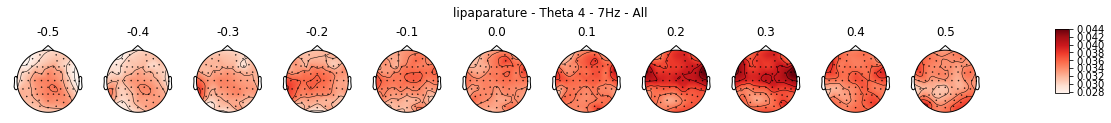

In [46]:
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz']
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz']

extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
extra_channels = ['lipaparature']

condition = ['Hyper','Normal','Hypo','All']
condition = ['All']
delay = np.arange(-5,6) / 10

for f in freq_band:
    A = []
    for feat in extra_channels:
        name = (feat,f)
        for d in delay:
            a = get_coherence_value(data,name,subject_name,d,condition)
            A.append(a)
    plot_coherence_preprocess_delay(A,name,condition,delay,info)

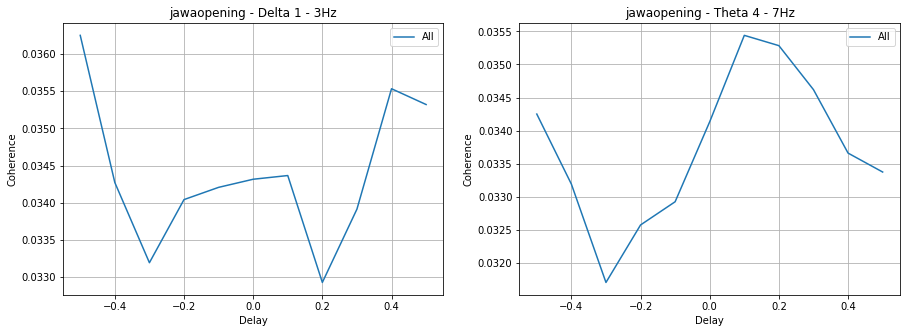

In [45]:
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz']
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz']

extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
extra_channels = ['jawaopening']

condition = ['Hyper','Normal','Hypo']
condition = ['All']

for feat in extra_channels:
    fig, axes = plt.subplots(1, 2,figsize=(15,5))
    for f in range(0,len(freq_band)):
        name = (feat,freq_band[f])
        delay = np.arange(-5,6) / 10
        a = get_coherence_value_delay(data,name,subject_name,delay,condition)
        ax=a.plot(grid=True,ax=axes[f],title=name[0]+' - '+name[1])
        ax= ax.set_ylabel('Coherence')

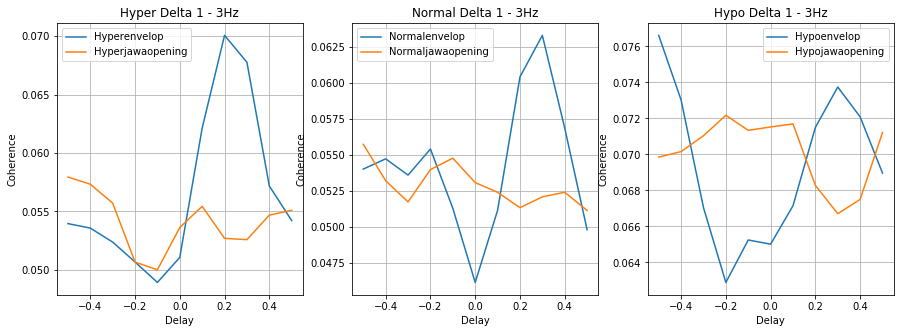

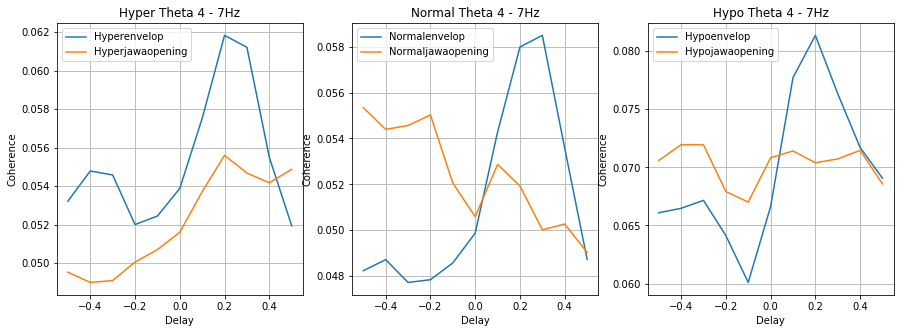

In [49]:
freq_band = ('Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz')
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz']

extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
extra_channels = ['envelop','jawaopening']

condition = ['Hyper','Normal','Hypo']
#condition = ['All']

for f in freq_band:
    
    frames=[]
    for feat in extra_channels:
        name = (feat,f)
        delay = np.arange(-5,6) / 10
        a = get_coherence_value_delay(data,name,subject_name,delay,condition)
        
        for c in condition:
            df = pd.DataFrame({c+feat:a[c]})
            frames.append(df)
            
    df=pd.concat((frames),axis=1)
    
    if(len(condition)!=1):
        fig, axes = plt.subplots(1, len(condition),figsize=(15,5))
    
    for c in range(0,len(condition)):
        a = df[[condition[c]+s for s in extra_channels]]
        if(len(condition)==1):
            ax = a.plot(grid=True,title=condition[c]+' '+name[1],figsize=(10,5))
        else:
            ax = a.plot(grid=True,title=condition[c]+' '+name[1],ax=axes[c])
        ax = ax.set_ylabel('Coherence')

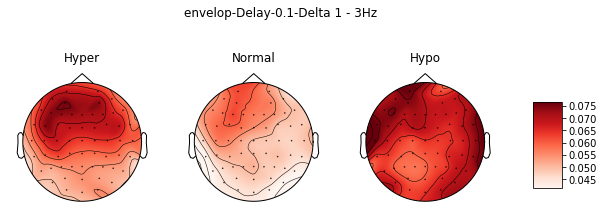

In [7]:
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz']
freq_band = ['Delta 1 - 3Hz']

extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
extra_channels = ['envelop']

condition = ['Hyper','Normal','Hypo']

for f in freq_band:
    for feat in extra_channels:
        name = (feat,f)
        delay = 0.1
        a = get_coherence_value(data,name,subject_name,delay,condition)
        plot_coherence_preprocess(a,name,condition,delay,info)

In [22]:
Hyper  = data.loc['envelop','Theta 4 - 7Hz','Hyper',0.3,subject_name]
Hyper['Data'].mean()

array([0.05560687, 0.05507446, 0.05548149, 0.05541937, 0.05857331,
       0.0540149 , 0.05473118, 0.05608336, 0.0587574 , 0.05749764,
       0.05543292, 0.0574329 , 0.05992582, 0.06059325, 0.05674436,
       0.05743519, 0.06013957, 0.05820117, 0.05975465, 0.05950889,
       0.05739149, 0.05793776, 0.05878256, 0.06010314, 0.05935551,
       0.05600672, 0.05563843, 0.05679031, 0.05539965, 0.052913  ,
       0.05482032, 0.0542517 , 0.05300193, 0.05514823, 0.05740111,
       0.05615587, 0.05225823, 0.05468318, 0.05693435, 0.05426684,
       0.05815539, 0.05759441, 0.06132453, 0.05835428, 0.05761042,
       0.05736507, 0.05847064, 0.06079013, 0.0590886 , 0.05784651,
       0.05636291, 0.05847842, 0.05971438, 0.05977433, 0.05479094,
       0.05686286, 0.06022844, 0.05955223, 0.05559246])